Presented by: Reza Saadatyar <br/>
E-mail: Reza.Saadatyar92@gmail.com

**Importing the required Libraries**

In [399]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy import signal
import matplotlib.pyplot as plt
from Plot_decision_regions import plot_decision_regions
from sklearn import datasets, preprocessing, model_selection, linear_model

**Functions**

In [389]:
# =============================================== Preparing data =========================================================
def preparing_data(data, labels):
    if data.shape[0] < data.shape[1]:
        data = data.T
    Labels = preprocessing.LabelEncoder()
    Labels = Labels.fit_transform(labels)
    return data, Labels
 
# ==================================================== Filtering =========================================================
def filtering(data, f_low, f_high, order, fs, filter_type="low"):
    if data.ndim > 1:
        if data.shape[0] > data.shape[1]:
            data = data.T
            
    f_low = f_low / (fs / 2)
    f_high = f_high / (fs / 2)
    
    if filter_type == "low":
        b, a = signal.butter(order, f_low, btype='low')
    elif filter_type == "high":
        b, a = signal.butter(order, f_high, btype='high')
    elif filter_type == "bandpass":
        b, a = signal.butter(order, [f_low, f_high], btype='bandpass')
    elif filter_type == "bandstop":
        b, a = signal.butter(order, [f_low, f_high], btype='bandstop')
    filtered_data = signal.filtfilt(b, a, data)
    
    return filtered_data.T

# ================================================= Plot data ============================================================
def plot_data(filtered_data, fs=None, first_point=0, last_point=100, val_ylim='', size_fig=(7,5), title='', display_figure="off"):
    
    if display_figure == "on":
        if filtered_data.shape[0] < filtered_data.shape[1]:
            filtered_data = filtered_data.T
            
        filtered_data = filtered_data[first_point:last_point,:]
        
        std = np.sort(np.std(filtered_data, axis=0))
        if len(std) > 100:
            std = np.mean(std[1:len(std)-1])
        else:
            std = np.mean(std)
        
        _, axs = plt.subplots(nrows=1, sharey='row', figsize=size_fig)
        offset = np.arange(filtered_data.shape[1]*std*val_ylim, 1, -std*val_ylim)
      
        if fs is not None and np.array(fs) > 0:
            time = (np.linspace(start=first_point/fs, stop=last_point/fs, num=len(filtered_data))).flatten()
            line = axs.plot(time, filtered_data + offset, linewidth=1)
            axs.set_xlabel('Time (sec)', fontsize=10)
        else:
            line = axs.plot(filtered_data + offset, linewidth=1)
            axs.set_xlabel('sample', fontsize=10)
        
        axs.set_title(title, fontsize=10)
        axs.set_yticks(offset)
        axs.set_yticklabels(["ch" + str(i) for i in range(1, filtered_data.shape[1] + 1)],  weight='bold')
        axs.tick_params(axis='x', labelsize=9)
        axs.tick_params(axis='y', labelsize=8)
        axs.set_ylabel('Channels', fontsize=10)
        axs.tick_params(axis='y', color='k', labelcolor='k')
        axs.grid(False)
        ytick_labels = plt.gca().get_yticklabels()
        for i, label in enumerate(ytick_labels):
            # line[i].set_color(line[i].get_color())
            label.set_color(line[i].get_color())
            
        axs.autoscale(enable=True, axis="x",tight=True)
        min = np.min(np.min(filtered_data + offset, axis=0))
        max = np.max(np.max(filtered_data + offset, axis=0))
        axs.set_ylim(min + min*0.02, max + max*0.01)

# ============================================== Data normalization ======================================================                          
def data_normalization(x_train, x_test, method=1):
    if x_train.ndim == 1:
        x_train = x_train.reshape(-1, 1)
        x_test = x_test.reshape(-1, 1)
        
    if method == 1:
        norm = preprocessing.MinMaxScaler()
    elif method == 2:
        norm = preprocessing.StandardScaler()
        
    x_train = norm.fit_transform(x_train)
    x_test = norm.transform(x_test)
    
    return x_train, x_test

# ================================================ Plot features =========================================================   
def plot_features(data, labels, fig_size=(4, 3), title="Data raw"):
   
   lab = np.unique(labels)
   colors = np.array(sns.color_palette("bright", len(lab))) 
 
   fig = plt.figure(figsize=fig_size)

   if data.shape[1] == 1:
      
      ax = fig.add_axes((0.15, 0.1, 0.64, 0.65))
      ax1 = fig.add_axes((0.16, 0.76, 0.62, 0.14))
      for i in range(0, len(lab)):
         
         tim = np.linspace(np.min(data[labels == lab[i], 0]), np.max(data[labels == lab[i], 0]), num=len(data[labels == lab[i], 0]), retstep=True)
         ax.plot(tim[0], data[labels == lab[i], 0], '.', markersize=10, color=colors[i, :])
         
         _, bins = np.histogram(data[labels == lab[i], 0], density=True)
         ax1.plot(bins, stats.norm.pdf(bins, np.mean(data[labels == lab[i], 0]), np.std(data[labels == lab[i], 0])), linewidth=1.5, color=colors[i, :], label=lab[i])
         ax1.fill_between(bins, y1=stats.norm.pdf(bins, np.mean(data[labels == lab[i], 0]), np.std(data[labels == lab[i], 0])), y2=0, alpha=0.4)
         
   elif data.shape[1] < 3:
      ax = fig.add_axes((0.15, 0.1, 0.64, 0.65))
      ax1 = fig.add_axes((0.16, 0.76, 0.62, 0.14))
      ax2 = fig.add_axes((0.8, 0.11, 0.14, 0.62))
      
      for i in range(0, len(lab)):
         
         ax.plot(data[labels == lab[i], 0], data[labels == lab[i], 1], '.', markersize=10, color=colors[i, :])
         
         _, bins = np.histogram(data[labels == lab[i], 0], density=True)
         ax1.plot(bins, stats.norm.pdf(bins, np.mean(data[labels == lab[i], 0]), np.std(data[labels == lab[i], 0])), linewidth=1.5, color=colors[i, :], label=lab[i])
         ax1.fill_between(bins, y1=stats.norm.pdf(bins, np.mean(data[labels == lab[i], 0]), np.std(data[labels == lab[i], 0])), y2=0, alpha=0.4)
         
         _, bins = np.histogram(data[labels == lab[i], 1], density=True)
         ax2.plot(stats.norm.pdf(bins, np.mean(data[labels == lab[i], 1]), np.std(data[labels == lab[i], 1])), bins, linewidth=2.5, color=colors[i, :])
         ax2.fill_betweenx(bins, stats.norm.pdf(bins, np.mean(data[labels == lab[i], 1]), np.std(data[labels == lab[i], 1])), 0, alpha=0.4, color=colors[i, :])
      
      ax.set_ylabel('Feature 2', fontsize=10,labelpad=0, va='center')
      ax2.spines[['top', 'right', 'bottom']].set_visible(False)
      ax2.tick_params(bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
            
   elif data.shape[1] > 2:
      
      ax = fig.add_axes((0.02, -0.05, 0.9, 0.9), projection="3d")
      ax1 = fig.add_axes((0.22, 0.67, 0.52, 0.16))
      ax2 = fig.add_axes((0.8, 0.18, 0.13, 0.47))
      ax3 = fig.add_axes((-0.05, 0.18, 0.13, 0.47))
      for i in range(0, len(lab)):
         
         ax.plot3D(data[labels == lab[i], 0], data[labels == lab[i], 1], data[labels == lab[i], 2], '.', markersize=10, color=colors[i, :], label=lab[i])
         
         _, bins = np.histogram(data[labels == lab[i], 0], density=True)
         ax1.plot(bins, stats.norm.pdf(bins, np.mean(data[labels == lab[i], 0]), np.std(data[labels == lab[i], 0])), linewidth=2.5, color=colors[i, :], label=lab[i])
         ax1.fill_between(bins, y1=stats.norm.pdf(bins, np.mean(data[labels == lab[i], 0]), np.std(data[labels == lab[i], 0])), y2=0, alpha=0.4, color=colors[i, :])
         
         _, bins = np.histogram(data[labels == lab[i], 1], density=True)
         ax2.plot(stats.norm.pdf(bins, np.mean(data[labels == lab[i], 1]), np.std(data[labels == lab[i], 1])), bins, linewidth=2.5, color=colors[i, :])
         ax2.fill_betweenx(bins, stats.norm.pdf(bins, np.mean(data[labels == lab[i], 1]), np.std(data[labels == lab[i], 1])), 0, alpha=0.4, color=colors[i, :])
         
         _, bins = np.histogram(data[labels == lab[i], 2], density=True)
         ax3.plot(-stats.norm.pdf(bins, np.mean(data[labels == lab[i], 2]), np.std(data[labels == lab[i], 2])), bins, linewidth=2.5, color=colors[i, :])
         ax3.fill_betweenx(bins, 0, -stats.norm.pdf(bins, np.mean(data[labels == lab[i], 2]), np.std(data[labels == lab[i], 2])), alpha=0.4, color=colors[i, :])
      
      ax.view_init(5, -120)
      # ax.dist = 9
      
      ax2.tick_params(bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
      ax3.tick_params(bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
      
      ax.tick_params(axis='z', which='both', bottom=False, top=False, labelbottom=True, labeltop=False, pad=-2)
      
      ax.margins(x=0), ax.margins(y=0), ax.margins(z=0)
      ax.set_ylabel('Feature 2', fontsize=10,labelpad=0, rotation=90, va='center')
      ax.set_zlabel('Feature 3', labelpad=-6, fontsize=10, va='center')
      
      ax2.spines[['top', 'right', 'bottom']].set_visible(False)
      ax3.spines[['top', 'bottom', 'left']].set_visible(False)

   pos1 = ax1.get_position()
   fig.suptitle(title, fontsize=10, y=pos1.y0 + 0.2)

   ax.grid(visible="on")
   ax.set_xlabel('Feature 1', labelpad=3, fontsize=10, va='center')
   ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True, labeltop=False, pad=-2)
   ax.tick_params(axis='y', width=0, which="major", bottom=False, top=False, labelbottom=True, labeltop=True, pad=-4, rotation=45)

   ax1.spines[['top', 'left', 'right']].set_visible(False)   
   ax1.tick_params(bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
   ax1.legend(title='Class', loc="best", ncol=3, handlelength=0.8, handletextpad=0.2, fontsize=8)  # bbox_to_anchor=(0.1, pos1.x1-0.02, pos1.x1-0.02, 0)

   plt.autoscale(enable=True, axis="x",tight=True)
   fig.subplots_adjust(top=1, bottom=0, left=0, right=1, wspace=0, hspace=0)
   
#    ax.yaxis.set_ticks(np.linspace(ax.get_yticks()[1], ax.get_yticks()[-2], int(len(ax.get_yticks()) / 2), dtype='int'))
# ax.tick_params(direction='in', length=6, width=2, colors='grey', grid_color='r', grid_alpha=0.5)
# ================================================  =========================================================    


**1. Load data**

In [423]:
method = 1
if method==1:
   x, y = datasets.make_classification(n_samples=1000,      # Number of samples in the dataset
                                       n_features=5,       # Number of total features
                                       n_informative=4,    # Number of informative features
                                       n_redundant=0,      # Number of redundant features
                                       n_classes=3,        # Number of classes in the dataset (binary classification in this case)
                                       random_state=1)     # Seed for reproducibility)
   # print(f"{x.shape=},\n{x=},\n{y=}")
elif method==2:
   iris = datasets.load_iris()
   x = iris.data
   y = iris.target
   # print(f"{iris.data.shape=},\n{iris.feature_names=},\n{iris.target_names=},\n{iris.data=},\n{iris.target}")

**2. Preparing the data**

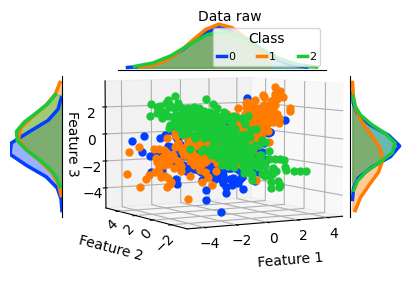

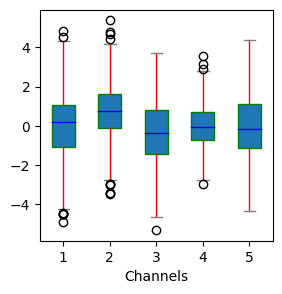

In [424]:
data, labels = preparing_data(x, y)
plot_features(data, labels, fig_size=(4, 3), title="Data raw")
# ------------------------------------------------------ Boxplot -------------------------------------------------------------
plt.figure(figsize=(3, 3))
plt.boxplot(data, boxprops=dict(color='green'), whiskerprops=dict(color='red'), medianprops=dict(color='blue'), capprops=dict(color='gray'), patch_artist=True)
plt.xlabel("Channels");

ValueError: x, y, and format string must not be None

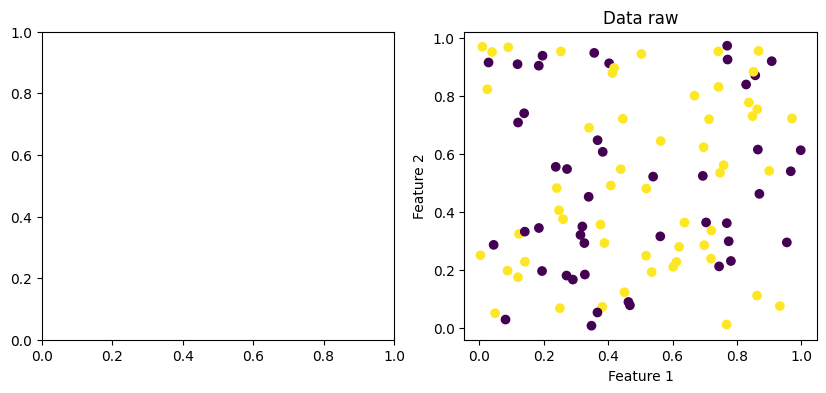

In [441]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
# ax1 = fig.add_subplot(2, 1, 1)  # 2 rows, 1 column, subplot 1
# plot_features(data, labels, fig_size=(4, 3), title="Data raw")
plot_features(data, labels, fig_size=(4, 3), title="Data raw")

TypeError: plot_features() got an unexpected keyword argument 'ax'

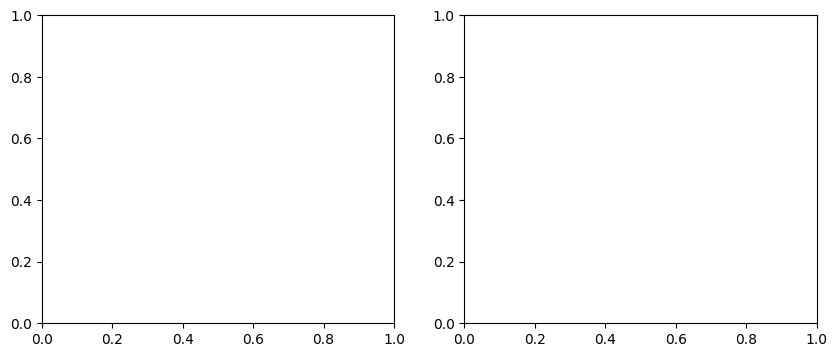

In [439]:
import matplotlib.pyplot as plt
import numpy as np

def plot_features(data, labels, fig_size=(4, 3), title="Data raw"):
    # Your plotting logic goes here
    # For example, you can plot data using plt.scatter or plt.plot

    # For demonstration, let's assume you are plotting a scatter plot
    plt.scatter(data[:, 0], data[:, 1], c=labels)
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

# Example data
data = np.random.rand(100, 2)
labels = np.random.randint(0, 2, size=100)

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plot data in the first subplot
plot_features(data, labels, fig_size=(4, 3), title="Data raw", ax=axes[0])

# Plot modified data in the second subplot
plot_features(data, labels, fig_size=(4, 3), title="Modified Data", ax=axes[1])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


**3. Filtering**<br/>

`Fs > f_high > f_low`

In [43]:
filtered_data = filtering(data, f_low=3, f_high=10, order=3, fs=50, filter_type="low")    # btype:'low','high','bandpass','bandstop'
plot_data(filtered_data, fs=None, first_point=0, last_point=500, val_ylim=3, size_fig=(7,5), title='filtered_data', display_figure="off")

**4. Split data**

In [407]:
data=data[:,0:2]

In [425]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(data, labels, test_size=0.3, random_state=42)

**5. Data normalization**

In [426]:
x_train, x_test = data_normalization(x_train, x_test, method=2)   # method 1: MinMaxScaler, method 2: StandardScaler

**6. Classification**

In [431]:
# ------------------------------------------------ LogisticRegression ----------------------------------------------------
model = linear_model.LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial', penalty='l2') # sag, newton-c,lbfg;  penalty='l2', Nonr
model.fit(x_train, y_train)

y_pred_train = model.predict(x_train) 
y_pred_test = model.predict(x_test)    #predict model

In [432]:
model.score(x_train, y_train)

0.6271428571428571

In [429]:
data.shape

(1000, 5)

C:\Users\Reza\AppData\Local\Temp\ipykernel_9756\2390761416.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.suptitle('Classification Type: ' + type_class+'; '+str(k_fold)+'th K-fold:', fontsize=12, y=pos1.x1), fig.show()


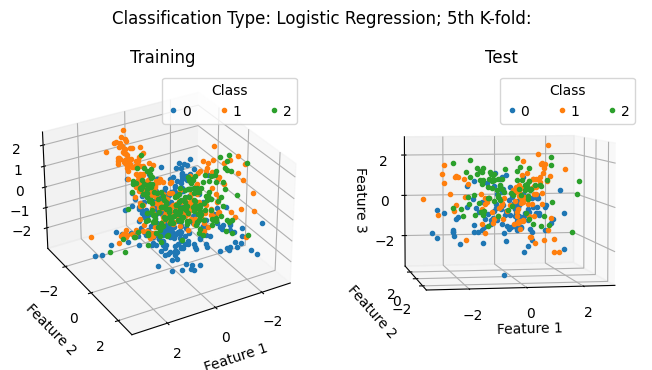

In [434]:
type_class = "Logistic Regression"
k_fold = 5
if x_train.shape[1] == 2:
        plot_decision_regions(x_train, y_train, x_test, y_test, model, type_class="Logistic Regression")
elif np.shape(x_train)[1] > 2:
        x_train = x_train[:, 0:3]
        x_test = x_test[:, 0:3]
        lab = np.unique(y_train)
        fig = plt.figure(figsize=(8, 5))
        ax1 = fig.add_subplot(121, projection='3d')
        ax2 = fig.add_subplot(122, projection='3d')

        for i in range(0, len(lab)):
            ax1.plot3D(x_train[y_pred_train == lab[i], 0], x_train[y_pred_train == lab[i], 1], x_train[y_pred_train == lab[i], 2], '.')
            ax2.plot3D(x_test[y_pred_test == lab[i], 0], x_test[y_pred_test == lab[i], 1], x_test[y_pred_test == lab[i], 2], '.')
            
        ax1.title.set_text('Training'), ax1.set_xlabel('Feature 1'), ax1.set_ylabel('Feature 2'), ax1.set_zlabel('Feature 3'),
        ax1.legend(lab, title='Class', ncol=3, handlelength=0.8, handletextpad=0.2), ax2.legend(lab, title='Class', ncol=3, handlelength=0.8, handletextpad=0.2)
        ax1.view_init(30, 60), ax2.view_init(5, -100), ax2.title.set_text('Test'), ax2.set_xlabel('Feature 1'), ax2.set_ylabel('Feature 2'), ax2.set_zlabel('Feature 3'),
        pos1 = ax2.get_position()
        fig.suptitle('Classification Type: ' + type_class+'; '+str(k_fold)+'th K-fold:', fontsize=12, y=pos1.x1), fig.show()

In [ ]:

def plot_classifier(data_train, label_train, data_test, label_test, label_predict_train, label_predict_test, k_fold,  model, type_class):
    if np.shape(data_train)[1] == 2:
        plot_decision_regions(data_train, label_train, data_test, label_test, model, type_class)
    elif np.shape(data_train)[1] == 3:
        lab_tr = np.unique(label_train)
        fig = plt.figure(figsize=(8, 5))
        ax1 = fig.add_subplot(121, projection='3d')
        ax2 = fig.add_subplot(122, projection='3d')

        for i in range(0, len(lab_tr)):
            ax1.plot3D(data_train[label_predict_train == lab_tr[i], 0], data_train[label_predict_train == lab_tr[i], 1], data_train[label_predict_train == lab_tr[i], 2], '.')
            ax2.plot3D(data_test[label_predict_test == lab_tr[i], 0], data_test[label_predict_test == lab_tr[i], 1], data_test[label_predict_test == lab_tr[i], 2], '.')
        ax1.title.set_text('Training'), ax1.set_xlabel('Feature 1'), ax1.set_ylabel('Feature 2'), ax1.set_zlabel('Feature 3'),
        ax1.legend(lab_tr, title='Class', ncol=3, handlelength=0.8, handletextpad=0.2), ax2.legend(lab_tr, title='Class', ncol=3, handlelength=0.8, handletextpad=0.2)
        ax1.view_init(30, 60), ax2.view_init(30, 60), ax2.title.set_text('Test'), ax2.set_xlabel('Feature 1'), ax2.set_ylabel('Feature 2'), ax2.set_zlabel('Feature 3'),
        pos1 = ax2.get_position()
        fig.suptitle('Classification Type: ' + type_class+'; '+str(k_fold)+'th K-fold:', fontsize=12, y=pos1.x1), fig.show()


In [ ]:
# ==========================================================================
# ============================ Machine Learning  ============================
# ====================== Presented by: Reza Saadatyar  =====================
# =================== E-mail: Reza.Saadatyar92@gmail.com  ==================
# ============================  2022-2023 ==================================
# The program will run automatically when you run code/file Main.py, and you do not need to run any of the other codes.

# ===================================== Importing the required Libraries =============================
from sklearn import datasets
from Filtering import filtering
from Clustering import clustering
from Preparing_data import preparing_data
from Normalize import normalize_data
from Classification import classification
from Plot_clustering import plot_cluster
from Feature_Selection import featureselection
from Feature_Extraction import feature_extraction
from Output_Training_Test_Network import output_network
# ============================================Step 1: Preparing the data ==============================================
iris = datasets.load_iris()
Data = iris.data
Labels = iris.target
# Data, Labels = datasets.make_blobs(150, 4, centers=4, random_state=0)
data, Labels = preparing_data(Data, Labels)
# ======================================== Step 2: Filtering & Data scaling ============================================
# Data = filtering(Data, F_low=5, F_high=10, Order=3, Fs=50, btype='bandpass')      # btype:'low', 'high', 'bandpass', 'bandstop'
# Data = normalize_data(Data, Type_Normalize='MinMaxScaler', Display_Figure='on')   # Type_Normalize:'MinMaxScaler', 'normalize'
# ======================================= Step 3: Feature Extraction & Selection =======================================
# Data = feature_extraction(Data, Labels, number_feature=3, number_neighbors=70, type_feature='LDA')
# Data = featureselection(Data, Labels, threshold=0.1, number_feature=3, c_l1fs=0.01, n_estimators_tfs=100,  type_feature='MI')
"""
Feature Extraction:
PCA:Principal Component Analysis; LDA:Linear discriminant analysis; ICA: Independent component analysis; SVD: Singular value decomposition
TSNE:T-distributed stochastic neighbor embedding; FA: Factor analysis; Isomap: Isometric Feature Mapping
Feature Selection:
Variance; Mutual information (MI); Chi-square test (Chi-square); fisher_score (FS); Forward feature selection (FFS);
Backward feature selection (BFS); Exhaustive Feature Selection (EFS); Recursive feature elimination (RFE); Random Forest (RF)
Univariate feature selection (UFS); L1-based feature selection (L1FS), Tree-based feature selection (TFS)
"""
# ===================================== Step 4: Classification & Clustering ==========================================
# ----------------------------------------- Step 4: Classification ---------------------------------------------------
model, type_class = classification(Data, Labels, type_class='XGBoost', hidden_layer_mlp=(10,), max_iter=200, kernel_svm='rbf',
                               c_svm=10, gamma_svm=0.7, max_depth=5, criterion_dt='entropy', n_estimators=500)
Accuracy_Train, Cr_Train, Accuracy_Test, Cr_Test = output_network(Data, Labels, model, type_class, k_fold=5)
"""
type_class: 'KNN', 'LR', 'MLP', 'SVM', 'DT', 'NB', 'RF', 'AdaBoost', 'XGBoost', 'LDA'
LR: LogisticRegression; MLP: Multilayer perceptron, SVM:Support Vector Machine; DT: Decision Tree; NB: Naive Bayes;
RF: Random Forest; AdaBoost; XGBoost; LDA: Linear Discriminant Analysis; KNN:K-Nearest Neighbors 
Parameters:
The number of hidden layers: hidden_layer_mlp; The number of epochs MLP: max_iter,
kernel_svm=‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’;  c_svm=Regularization parameter, 
gamma_svm=Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. 
max_depth=The maximum depth of the tree, random forest and XGBoost; criterion= 'gini', 'entropy', 'log_loss';
n_estimators:The number of trees in the forest.
"""
# ----------------------------------------- Step 4: Clustering -----------------------------------------------------
clustering(Data, n_clusters=3, max_iter=100, thr_brich=0.5,  branchfactor_brich=50, n_neighbor_SpecCluster=10,
           minsamples_optics=15, max_dist_optics=5, batch_size_MBKmeans=10, type_cluster='MiniBatchKMeans')
"""
type_cluster: kmeans; Agglomerative; DBSCAN; GMM:Gaussian Mixture Models; Meanshift; Birch; SpectralClustering; 
OPTICS; MiniBatchKMeans
"""


In [ ]:
from xgboost import XGBClassifier
from KNN_Neighbors_Optimal import KNN_Optimal
from sklearn import model_selection, linear_model, multiclass, neural_network, svm, tree, naive_bayes, neighbors, ensemble, discriminant_analysis


def classification(data, labels, type_class, hidden_layer_mlp, max_iter, kernel_svm, c_svm, gamma_svm, max_depth, criterion_dt, n_estimators):
    if type_class == 'LR':
        model = multiclass.OneVsRestClassifier(linear_model.LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial', penalty='l2'))  # sag, newton-c,lbfg;  penalty='l2', Nonr
    elif type_class == 'MLP':
        model = neural_network.MLPClassifier(hidden_layer_sizes=hidden_layer_mlp, max_iter=max_iter, alpha=1e-4, learning_rate='invscaling', solver='lbfgs',
                                             random_state=0, verbose=False, learning_rate_init=0.05)
    elif type_class == 'SVM':
        model = svm.SVC(kernel=kernel_svm, random_state=0, C=c_svm, gamma=gamma_svm, probability=True)  # kernel='rbf', 'poly', 'linear'
    elif type_class == 'DT':
        model = tree.DecisionTreeClassifier(criterion=criterion_dt, max_depth=max_depth, random_state=0)
    elif type_class == 'NB':
        model = naive_bayes.GaussianNB()
    elif type_class == 'RF':
        model = ensemble.RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, criterion=criterion_dt, random_state=0)
    elif type_class == 'AdaBoost':
        # model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
        # model = ensemble.AdaBoostClassifier(base_estimator=model, n_estimators=100, random_state=0)
        model = ensemble.AdaBoostClassifier(n_estimators=n_estimators, learning_rate=1, random_state=0)
    elif type_class == 'XGBoost':
        model = XGBClassifier(max_depth=max_depth, n_estimators=n_estimators, learning_rate=0.01, random_state=0, objective='multi:softprob')
    elif type_class == 'LDA':
        model = discriminant_analysis.LinearDiscriminantAnalysis(n_components=len(np.unique(labels)) - 1)
    elif type_class == 'KNN':
        data_train, data_test, label_train, label_test = model_selection.train_test_split(data, labels, test_size=0.3, random_state=1)
        num_k = KNN_Optimal(data_train, label_train, data_test, label_test, N=21)  # Obtain optimal K
        model = neighbors.KNeighborsClassifier(n_neighbors=num_k, metric='minkowski')
    return model, type_class

In [ ]:
x = np.random.randn(1000)
y = np.random.randn(1000)

left, width = 0.1, 0.65
bottom= 0.1
width = 0.65
height =0.65
bottom_h =  left+width+0.02
left_h   = left+width+0.02

rect_scatter = [left, bottom, width, height]
rect_histx   = [left, bottom_h, width, 0.2]
rect_histy   = [left_h, bottom, 0.2, height] 
plt.figure(1, figsize=(8,8))
axScatter = plt.axes(rect_scatter)
axHistx   = plt.axes(rect_histx)
axHisty   = plt.axes(rect_histy)

plt.figure(1, figsize=(8,8))
axScatter = plt.axes(rect_scatter)
axHistx   = plt.axes(rect_histx)
axHisty   = plt.axes(rect_histy)

axScatter.scatter(x, y,c='r')

binwidth = 0.25
xymax = np.max( [np.max(np.fabs(x)), np.max(np.fabs(y))] )
lim = ( int(xymax/binwidth) + 1) * binwidth
axScatter.set_xlim( (-lim, lim) )
axScatter.set_ylim( (-lim, lim) )
bins = np.arange(-lim, lim + binwidth, binwidth)

axHistx.hist(x, bins=bins,color='green')

axHisty.hist(y, bins=bins, orientation='horizontal',color='b')

axHistx.set_xlim( axScatter.get_xlim() );
axHisty.set_ylim( axScatter.get_ylim() );